In [2]:
import os
import numpy as np

def load_fasta(file_path):
    sequences = {}
    header = None
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                header = line[1:]
                sequences[header] = ''
            else:
                sequences[header] += line
    return sequences[header]

def load_bpseq(file_path):
    structure = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3:
                idx = int(parts[0])
                nucleotide = parts[1]
                pair = int(parts[2])
                structure.append((idx, nucleotide, pair))
    return structure

def load_data(fasta_dir, bpseq_dir):
    fasta_files = [f for f in os.listdir(fasta_dir) if f.endswith('.fa')]
    bpseq_files = [f for f in os.listdir(bpseq_dir) if f.endswith('.bpseq')]

    sequences = {}
    structures = {}

    for fasta_file in fasta_files:
        header = os.path.splitext(fasta_file)[0]
        fasta_path = os.path.join(fasta_dir, fasta_file)
        sequences[header] = load_fasta(fasta_path)

    for bpseq_file in bpseq_files:
        header = os.path.splitext(bpseq_file)[0]
        bpseq_path = os.path.join(bpseq_dir, bpseq_file)
        structures[header] = load_bpseq(bpseq_path)

    return sequences, structures

sequences, structures = load_data('ArchiveII/', 'ArchiveII/')
print("Liczba wczytanych sekwencji:", len(sequences))
print("Liczba wczytanych struktur:", len(structures))


Liczba wczytanych sekwencji: 3970
Liczba wczytanych struktur: 3970


In [16]:
def one_hot_encode_sequence(seq):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'U': 3}
    one_hot = np.zeros((len(seq), 4), dtype=int)
    for i, nucleotide in enumerate(seq):
        one_hot[i, mapping[nucleotide.upper()]] = 1
    return one_hot

encoded_sequences = {header: one_hot_encode_sequence(seq) for header, seq in sequences.items()}
# encoded_sequences


In [4]:

heds = []
def encode_structure(structure, seq_length):
    encoded = np.zeros(seq_length, dtype=int)
    for idx, _, pair in structure:
        if pair != 0:
            encoded[idx - 1] = 1
            encoded[pair - 1] = 1
    return encoded

encoded_structures = {header: encode_structure(struct, len(structures[header])) for header, struct in structures.items() if header in sequences.keys()}


In [5]:
print(f"Sequences keys: {list(sequences.keys())[:5]}")
print(f"Structures keys: {list(structures.keys())[:5]}")

print(f"Encoded sequences: {len(encoded_sequences)}")
print(f"Encoded structures: {len(encoded_structures)}")


Sequences keys: ['16s_A.fulgidus', '16s_A.fulgidus_domain1', '16s_A.fulgidus_domain2', '16s_A.fulgidus_domain3', '16s_A.fulgidus_domain4']
Structures keys: ['16s_A.fulgidus', '16s_A.fulgidus_domain1', '16s_A.fulgidus_domain2', '16s_A.fulgidus_domain3', '16s_A.fulgidus_domain4']
Encoded sequences: 3970
Encoded structures: 3970


In [6]:
from sklearn.model_selection import train_test_split

def prepare_data(sequences, structures):
    X_list = []
    y_list = []
    max_seq_length = max(len(seq) for seq in sequences.values())
    max_struct_length = max(len(struct) for struct in structures.values())
    for header in sequences.keys():
        seq = sequences[header]
        struct = structures[header]
        seq_array = np.zeros((max_seq_length, 4))  # padding
        struct_array = np.zeros(max_struct_length)  
        for i in range(len(seq)):
            if seq[i] in ['A', 'C', 'G', 'U']:  # nuclei check
                if seq[i] == 'A':
                    seq_array[i, 0] = 1
                elif seq[i] == 'C':
                    seq_array[i, 1] = 1
                elif seq[i] == 'G':
                    seq_array[i, 2] = 1
                elif seq[i] == 'U':
                    seq_array[i, 3] = 1
        for i in range(len(struct)):
            if struct[i] != 0:  
                struct_array[i] = 1
        X_list.append(seq_array)
        y_list.append(struct_array)
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y


X, y = prepare_data(encoded_sequences, encoded_structures)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


C:\Users\tomek\AppData\Local\Temp/ipykernel_28200/1655807189.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if seq[i] in ['A', 'C', 'G', 'U']:  # nuclei check


In [8]:
(X_train.shape[1], X_train.shape[2])


In [119]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, concatenate

def unet(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = Conv1D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling1D(2)(conv1)
    conv2 = Conv1D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling1D(2)(conv2)
    conv3 = Conv1D(256, 3, activation='relu', padding='same')(pool2)
    
    # Decoder
    up1 = UpSampling1D(2)(conv3)
    upconv1 = Conv1D(128, 2, activation='relu', padding='same')(up1)
    concat1 = concatenate([conv2, upconv1], axis=2)
    conv4 = Conv1D(128, 3, activation='relu', padding='same')(concat1)
    up2 = UpSampling1D(2)(conv4)
    upconv2 = Conv1D(64, 2, activation='relu', padding='same')(up2)
    concat2 = concatenate([conv1, upconv2], axis=2)
    conv5 = Conv1D(64, 3, activation='relu', padding='same')(concat2)
    
    # Output
    outputs = Conv1D(1, 1, activation='sigmoid')(conv5)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = unet(input_shape)

history = model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
87/87 [==============================] - 109s 851ms/step - loss: 0.6738 - accuracy: 0.9597
Epoch 2/50
87/87 [==============================] - 76s 871ms/step - loss: 0.6363 - accuracy: 0.9597
Epoch 3/50
87/87 [==============================] - 76s 871ms/step - loss: 0.6015 - accuracy: 0.9597
Epoch 4/50
87/87 [==============================] - 72s 826ms/step - loss: 0.5692 - accuracy: 0.9597
Epoch 5/50
87/87 [==============================] - 73s 842ms/step - loss: 0.5393 - accuracy: 0.9597
Epoch 6/50
87/87 [==============================] - 72s 827ms/step - loss: 0.5116 - accuracy: 0.9597
Epoch 7/50
87/87 [==============================] - 81s 929ms/step - loss: 0.4859 - accuracy: 0.9597
Epoch 8/50
87/87 [==============================] - 69s 797ms/step - loss: 0.4621 - accuracy: 0.9597
Epoch 9/50
87/87 [==============================] - 69s 798ms/step - loss: 0.4401 - accuracy: 0.9597
Epoch 10/50
87/87 [==============================] - 69s 797ms/step - loss: 0.4197 - accur

In [120]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')
model.save('model_archive.h5')

19/19 [==============================] - 5s 210ms/step - loss: 0.1733 - accuracy: 0.9609
Test Accuracy: 0.9609097242355347


In [12]:
model_new = unet(input_shape)

history_new = model_new.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
87/87 [==============================] - 116s 926ms/step - loss: 0.6738 - accuracy: 0.9597 - val_loss: 0.6543 - val_accuracy: 0.9610
Epoch 2/10
87/87 [==============================] - 80s 920ms/step - loss: 0.6364 - accuracy: 0.9597 - val_loss: 0.6181 - val_accuracy: 0.9610
Epoch 3/10
87/87 [==============================] - 77s 890ms/step - loss: 0.6016 - accuracy: 0.9597 - val_loss: 0.5845 - val_accuracy: 0.9610
Epoch 4/10
87/87 [==============================] - 75s 866ms/step - loss: 0.5693 - accuracy: 0.9597 - val_loss: 0.5533 - val_accuracy: 0.9610
Epoch 5/10
87/87 [==============================] - 75s 866ms/step - loss: 0.5393 - accuracy: 0.9597 - val_loss: 0.5244 - val_accuracy: 0.9610
Epoch 6/10
87/87 [==============================] - 76s 874ms/step - loss: 0.5116 - accuracy: 0.9597 - val_loss: 0.4976 - val_accuracy: 0.9610
Epoch 7/10
87/87 [==============================] - 76s 876ms/step - loss: 0.4859 - accuracy: 0.9597 - val_loss: 0.4728 - val_accuracy: 0.961

In [13]:
loss, accuracy = model_new.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

19/19 [==============================] - 4s 216ms/step - loss: 0.4091 - accuracy: 0.9609
Test Accuracy: 0.9609097242355347


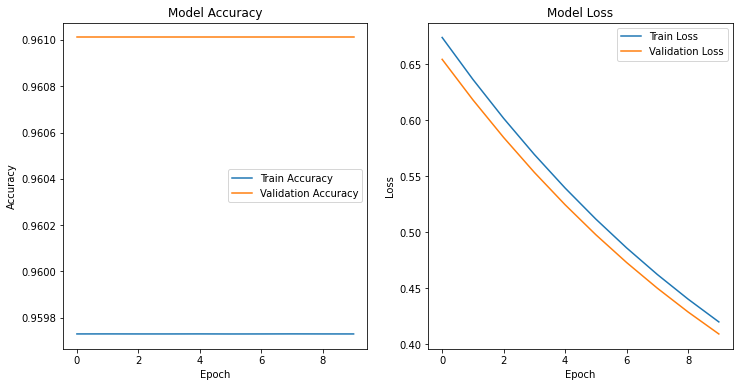

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_new.history['accuracy'], label='Train Accuracy')
plt.plot(history_new.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_new.history['loss'], label='Train Loss')
plt.plot(history_new.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("acc_val_archiveII.pdf")
plt.show()
